<a href="https://colab.research.google.com/github/pentagram5/DeepLearning/blob/master/DL_GAN%2C_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# 생성적 적대 신경망(Generative Adversarial Networks)_GAN
* 딥러닝의 원리를 활용해 가상의 이미지를 생성하는 알고리즘 
* 이미지 픽셀들을 어떻게 조합해야 우리가 생각하는 '얼굴'의 형상이 되는지를 딥러닝 알고리즘이 예측한 결과가 가상의 이미지가 된다. 
* GAN이라는 이름에는 적대적이라는 단어가 들어가고, 알고리즘의 성격을 보여준다. 
* 진짜 같은 '가짜'를 만들기 위해 알고리즘 내부에서 '적대적' 인 경합을 진행하기 때문. 
* 한쪽은 가짜를 만들고, 한쪽은 진짜와 비교하는 경합의 과정을 이용한 것이 GAN의원리 

## 1.가짜 제조 공장, 생성자. 
* 생성자(Generator)는 가상의 이미지를 만들어 내는 공장이다. 
* 처음 랜덤한 픽셀값으로 채워진 가짜 이미지들로 시작해, 판별자의 판별결과에 따라 지속적으로 업데이트하며 점차 원하는 이미지를 만든다. 
* DCGAN(Deep Convolution GAN) 은 최적화, 컴파일 과정이 없고, 패딩 과정이 필요하다. -> 입력과 출력의 크기를 맞추기 위해서. 
* 입력과 출력을 맞춰야지만, 판별자가 비교할 '진짜'와 똑같은 크기가 된다. 
* DCGAN에선  또한. 배치정규화라는 과정이 필요하다 이과정은 입력데이터의 평균이 0, 분산이 1이 되도록 재배치하는 것. 
* 다음층으로 입력될 값을 일정하게 재배치하는 역할을 한다. 이 과정을 통해 층의 개수가 늘어나도 안정적인 학습을 진행할 수 있다. 
* 생성자의 활성화 함수는 Relu(), 판별자로 넘기기전에는 tanh()함수를 쓴다 -> 출력 값이 -1 ~ 1 사이로 맞춰진다. 

In [13]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

generator = Sequential()
generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2)))

* generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2)))에서 128은 임의로 정한 노드의수, 굳이 128이아니어도 충분한 노드를 마련해주면된다. Input_dim=100은 100차원 크기의 랜덤 벡터를 준비해 집어넣으라는 뜻
* 주의할 점은 7*7이다. 이미지의 최초크기를 말하는데 우리가 실습할 MNIST 손글씨 이미지는 28*28이다. 
* 하지만 후에 Upsampling2D()함수로 가로 세로 크기를 2배씩 늘려주기 때문에 두번의 업셈플링을 거쳐 28*28크기로 만들어 질수 있다.
* 작은 크기의 이미지를 점점 키우면서 컨볼루션 레이어를 지나가게 하는 것이 DCGAN의 특징

In [14]:
generator.add(BatchNormalization())# 배치 정규화로, 다음 층에 입력될 값을 일정하게 재배치 해줌
generator.add(Reshape((7,7,128))) # 컨벌루션 레이어가 받아들일 수 있는 형태로 바꿔주는 코드 
#Conv2D()함수의 input_shape 부분에 들어가 ㄹ형태로 정해준다. 

In [15]:
generator.add(UpSampling2D())#가로 세로의 픽셀단위의 크기를 두배로 늘려줌
generator.add(Conv2D(64, kernel_size=5, padding = 'same'))

* Upsampling을 거쳐 두배씩 키워 샘플링한후. 커널 크기를 5으로해서 5*5크기의 마스크를 Conv2D함수를 거쳐 씌운다. padding = 'same' 조건으로 모자라는 부분을 자동으로 0으로 채운다. 

In [16]:
generator.add(BatchNormalization())# 배치 정규화로, 다음 층에 입력될 값을 일정하게 재배치 해줌
generator.add(Activation(LeakyReLU(0.2)))# 생성자의 활성화 함수 -> LeakyReLU
#GAN에서는 기존 ReLU()를 쓰면 불안정해지는 경우가 많아, 조금 변형한 LeakyReLU를 써준다. 

* LeakyReLU()함수는 ReLU() 함수에서 x값이 음수이면 무조건 0이 되어 뉴런들이 일찍 소실되는 단점을 보안해준다. 즉 0이하에서도 작은 값을 가지게 만드는 활성화 함수.
* 여기서 LeakyReLU(0.2)는 0보다 작을 경우 0.2를 곱하라는 의미

In [17]:
generator.add(UpSampling2D())#가로 세로의 픽셀단위의 크기를 두배로 늘려줌
generator.add(Conv2D(1, kernel_size=5, padding='same', activation = 'tanh')) #판별자로 넘기기위 해 tanh사용, 값이 -1~1사이로 맞춰진다.

* 끝으로 한번더 배치정규화를 거치고, Conv2D() 함수를 통해 한번더 컨볼루션 을 거친후 판별자로 값을 넘길 준비를 마친다. 활성화 함수로는 tanh를 써준다. 여기까지가 생성자의 layer이다.

## 2.진위를 가려내는 장치.판별자
* 넘어온 이미지가 가짜인지 진짜 인지를 판별해줄 장치인 판별자(discriminator)를 만들 차례이다.
* 진짜(1) or 가짜(0), 둘 중 하나를 결정하는 문제이므로, 컴파일 부분은 로스함수와 최적화 함수를 그대로쓸것이다. 드롭아웃, 배치정규화, 패딩도 넣어준다.
* 하지만 유의할 점은 자기 자신이 학습을 해선 안된다.판별자가 얻은 가중치는 생성자로 넘겨주어 생성자가 업데이트된 이미지를 만들도록 해야한다. 
* 따라서 판별자를 만들 때는 가중치를 저장하는 학습기능을 꺼주어야한다. 

In [18]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = 5, strides =2, input_shape=(28,28,1), padding ='same'))
#각 노드수는 64,128 개로 정할것이고 커널 크기는 5로 설정해 5*5마스크가 사용된다. input_shape은 생성자의 마지막 픽셀형태와 같다. 
#stride 옵션은 마스크를 몇칸씩 이동시킬지 정하는 옵션 -> 가로, 세로크기가 더줄어들어 새로운 특징을 뽑아주는 효과가 있다. 
#판별자는 업셈플링을 통해 가로 세로를 늘려주었지만, 판별자는 진짜와 가짜만 구분하면 되기때문에 그럴필요가 없다. 
#stride나 드롭아웃, 차원을 줄여주는 기능을 적극적으로 사용해 컨벌루션 신경망 본래의 목적을 달성해주면된다. 

In [19]:
discriminator.add(Activation(LeakyReLU(0.2))) #활성화 함수 ->LeakyReLU(0.2)
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding = 'same'))
discriminator.add(Activation(LeakyReLU(0.2))) #활성화 함수 ->LeakyReLU(0.2)
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())#로스와 시그모이드에 적용되기 위해(진짜가짜판별) 2차원을 1차원으로 바꿔주어야한다.
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')
discriminator.trainable = False #판별이 끝나고 나면 자신이 학습되지 않게끔 학습 기능을 꺼준다. 

## 3.적대적 신경망(GAN) 실행하기 

In [20]:
ginput = Input(shape=(100,))

dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


epoch:0 d_loss:0.6758 g_loss:0.6235
epoch:1 d_loss:0.4253 g_loss:0.2760
epoch:2 d_loss:0.3994 g_loss:0.0520
epoch:3 d_loss:0.5298 g_loss:0.0126
epoch:4 d_loss:0.6117 g_loss:0.0229
epoch:5 d_loss:0.5570 g_loss:0.0843
epoch:6 d_loss:0.4894 g_loss:0.3438
epoch:7 d_loss:0.5215 g_loss:0.5353
epoch:8 d_loss:0.5512 g_loss:0.5379
epoch:9 d_loss:0.5218 g_loss:0.5126
epoch:10 d_loss:0.4725 g_loss:0.5345
epoch:11 d_loss:0.4136 g_loss:0.6766
epoch:12 d_loss:0.3675 g_loss:0.9581
epoch:13 d_loss:0.2810 g_loss:1.3881
epoch:14 d_loss:0.2711 g_loss:2.0952
epoch:15 d_loss:0.2321 g_loss:2.7261
epoch:16 d_loss:0.4797 g_loss:2.0493
epoch:17 d_loss:0.4871 g_loss:1.6865
epoch:18 d_loss:0.5831 g_loss:0.7402
epoch:19 d_loss:0.6881 g_loss:1.2293
epoch:20 d_loss:0.4912 g_loss:1.7196
epoch:21 d_loss:0.5623 g_loss:1.1480
epoch:22 d_loss:0.5243 g_loss:0.9081
epoch:23 d_loss:0.3767 g_loss:0.9469
epoch:24 d_loss:0.2722 g_loss:1.3891
epoch:25 d_loss:0.2868 g_loss:1.3708
epoch:26 d_loss:0.2955 g_loss:1.2967
epoch:27 d_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
epoch:5002 d_loss:0.5771 g_loss:2.0398
epoch:5003 d_loss:0.3721 g_loss:1.7337
epoch:5004 d_loss:0.5395 g_loss:1.5769
epoch:5005 d_loss:0.5284 g_loss:1.4456
epoch:5006 d_loss:0.5442 g_loss:1.2858
epoch:5007 d_loss:0.4760 g_loss:1.5325
epoch:5008 d_loss:0.6290 g_loss:1.3463
epoch:5009 d_loss:0.4317 g_loss:1.7205
epoch:5010 d_loss:0.6179 g_loss:1.7073
epoch:5011 d_loss:0.4255 g_loss:1.7102
epoch:5012 d_loss:0.4529 g_loss:1.5609
epoch:5013 d_loss:0.4906 g_loss:1.6550
epoch:5014 d_loss:0.6028 g_loss:1.6321
epoch:5015 d_loss:0.4766 g_loss:1.2629
epoch:5016 d_loss:0.6443 g_loss:1.5938
epoch:5017 d_loss:0.4369 g_loss:1.9095
epoch:5018 d_loss:0.5339 g_loss:1.5914
epoch:5019 d_loss:0.4593 g_loss:1.9542
epoch:5020 d_loss:0.5754 g_loss:1.8252
epoch:5021 d_loss:0.5393 g_loss:1.2648
epoch:5022 d_loss:0.5684 g_loss:1.4882
epoch:5023 d_loss:0.4519 g_loss:1.9226
epoch:5024 d_loss:0.3910 g_loss:1.6109
epoch:5025 d_loss:0.4037 g_loss:2.2848
epoch:5026 d_loss:0.5531 g_l

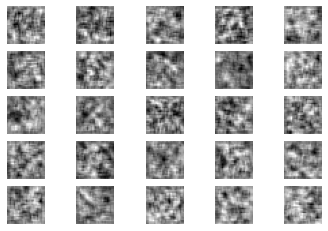

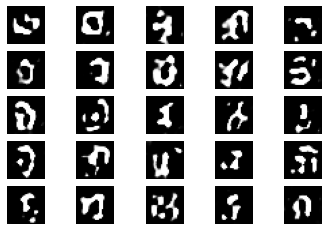

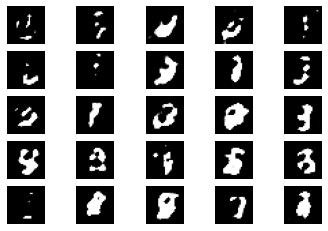

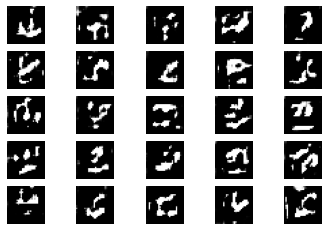

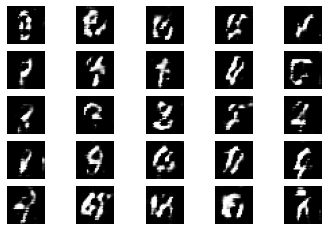

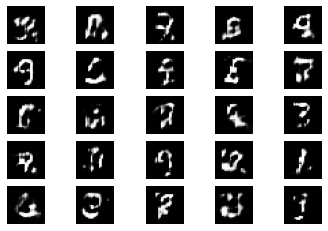

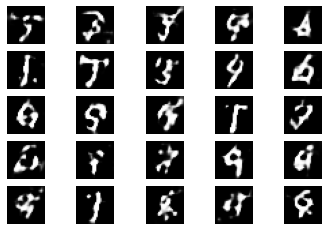

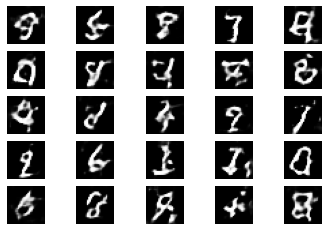

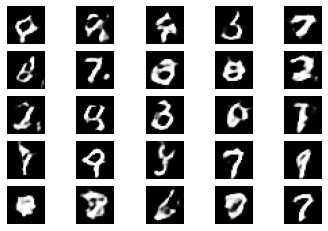

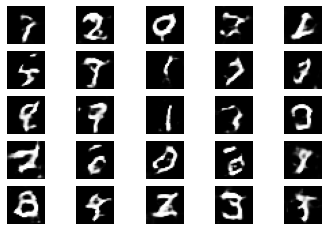

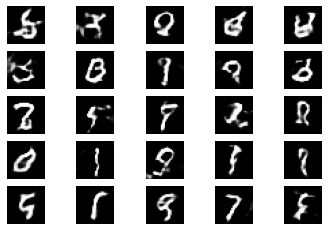

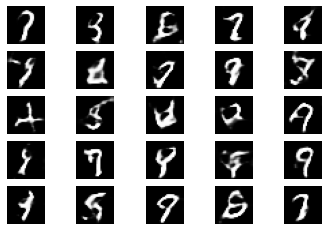

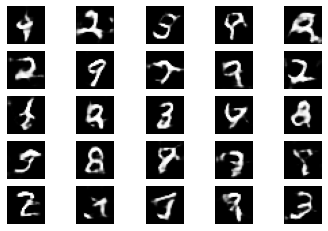

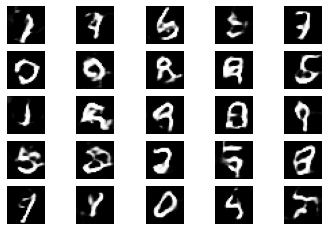

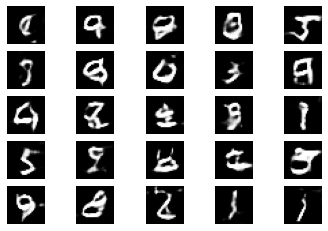

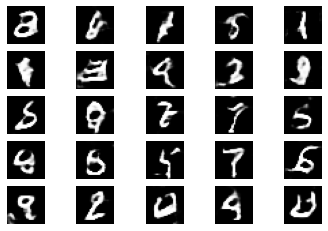

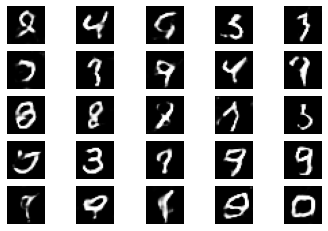

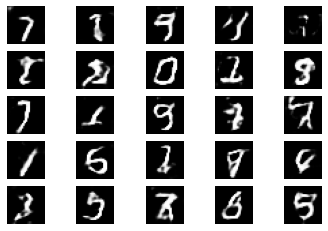

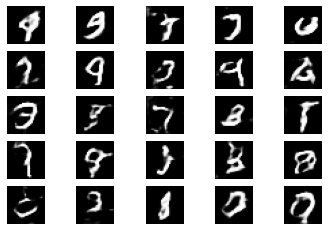

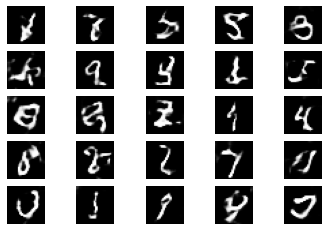

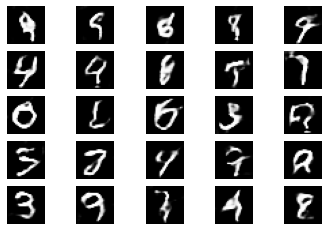

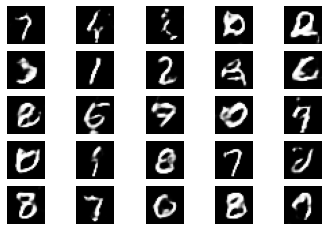

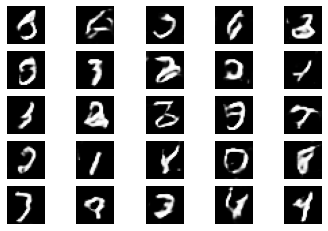

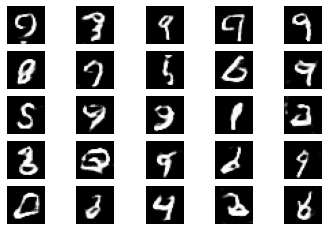

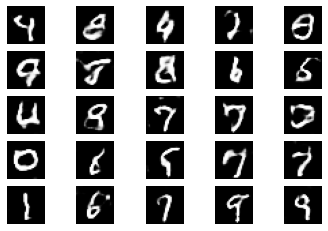

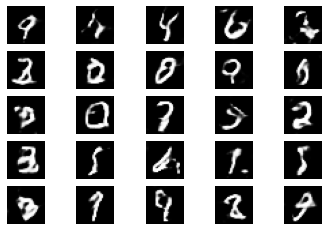

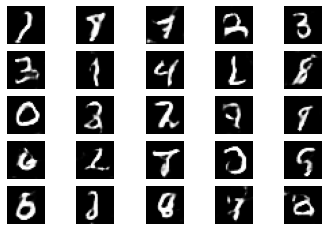

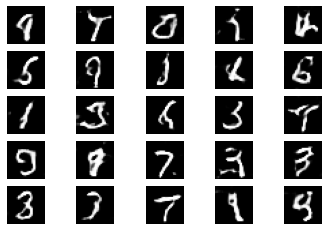

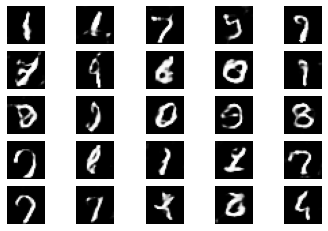

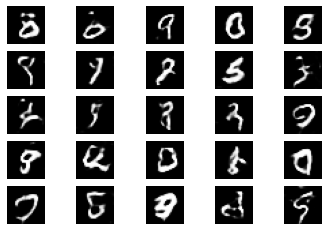

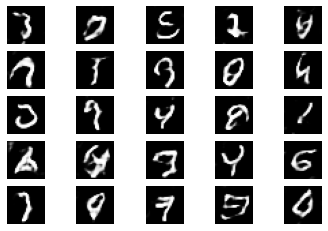

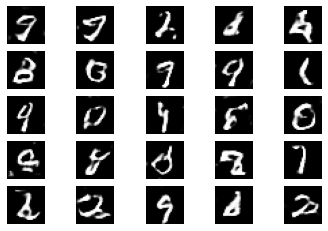

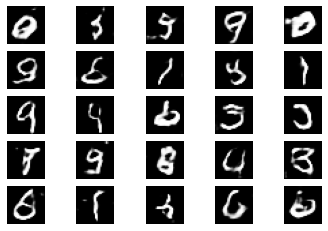

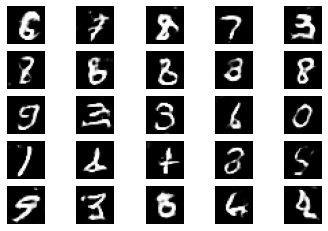

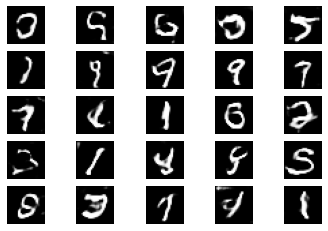

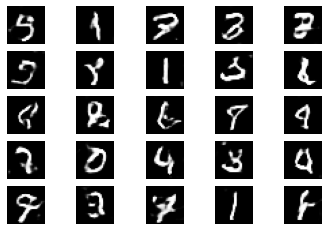

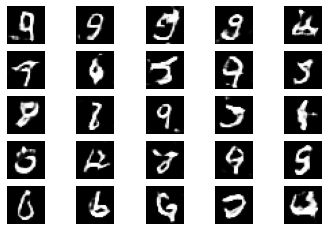

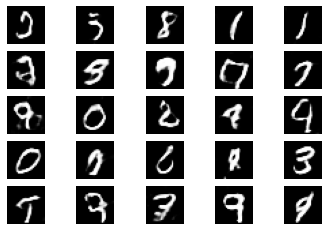

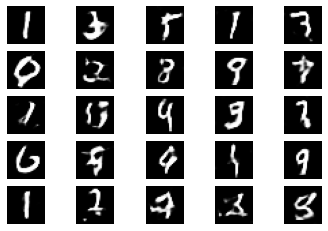

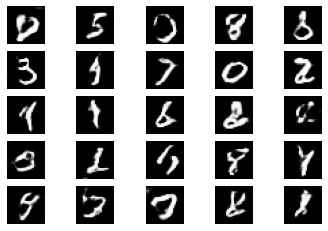

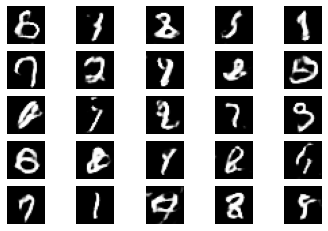

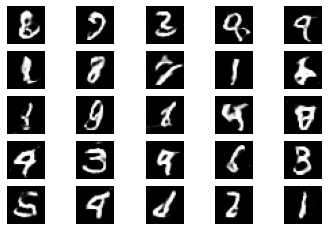

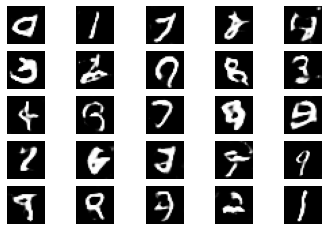

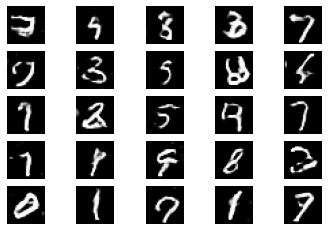

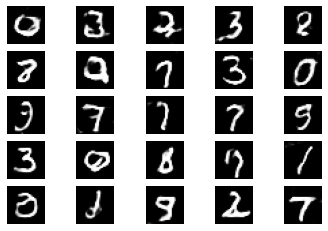

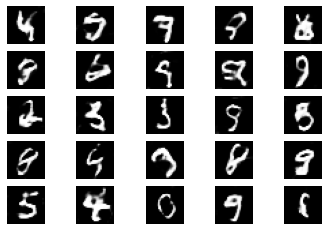

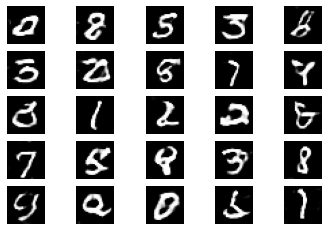

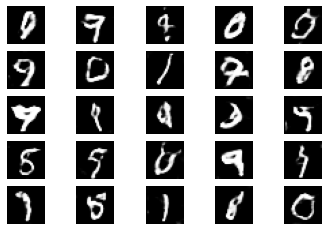

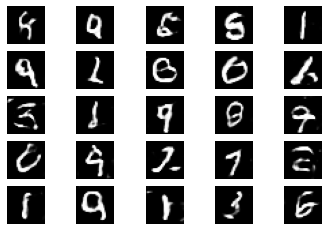

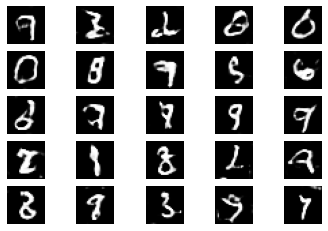

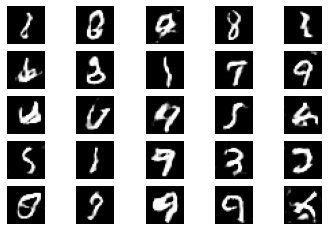

In [21]:
# 신경망 실행시키는 함수 만들기 
def gan_train(epoch, batch_size, saving_interval):
  (X_train, _), (_,_) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

  X_train = (X_train -127.5)/127.5
  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):

    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    noise = np.random.normal(0,1, (batch_size,100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)

    print('epoch:%d'% i, 'd_loss:%.4f' % d_loss, 'g_loss:%.4f' % g_loss)

    #중간과정을 이미지로 저장하는 부분 
    if i % saving_interval ==0:
      noise = np.random.normal(0,1,(25,100))
      gen_imgs = generator.predict(noise)

      gen_imgs = 0.5 * gen_imgs +0.5
      fig, axs = plt.subplots(5,5)
      count = 0
      for j in range(5):
        for k in range(5):
          axs[j,k].imshow(gen_imgs[count,:,:,0], cmap = 'gray')
          axs[j,k].axis('off')
          count += 1
      """images_dir = '/content/gdrive/My Drive/data/Mnist_GAN_image'
      fig.savefig(f"{images_dir}/\gan_mnist_%d.png" %i)"""

gan_train(10001,32,200)